开始实验 3: 非可分数据下的全批次 GD 训练...
Step 10000/100000, Loss: 0.087533, Trajectory Error: 9.19e-14
Step 20000/100000, Loss: 0.059321, Trajectory Error: 1.09e-13
Step 30000/100000, Loss: 0.049188, Trajectory Error: 9.29e-14
Step 40000/100000, Loss: 0.043230, Trajectory Error: 1.01e-13
Step 50000/100000, Loss: 0.039045, Trajectory Error: 1.42e-13
Step 60000/100000, Loss: 0.035825, Trajectory Error: 1.85e-13
Step 70000/100000, Loss: 0.033208, Trajectory Error: 1.66e-13
Step 80000/100000, Loss: 0.031031, Trajectory Error: 4.22e-13
Step 90000/100000, Loss: 0.029226, Trajectory Error: 4.97e-13
Step 100000/100000, Loss: 0.027701, Trajectory Error: 4.97e-13

--- 训练结束，结果汇总 ---
最大轨迹误差 (Max Trajectory Error): 5.5697e-13
小网络最终参数范数 (Final Weight Norm of Small Net): 41.1259
大网络最终参数范数 (Final Weight Norm of Large Net): 41.1259
---------------------------

开始绘制实验结果图...


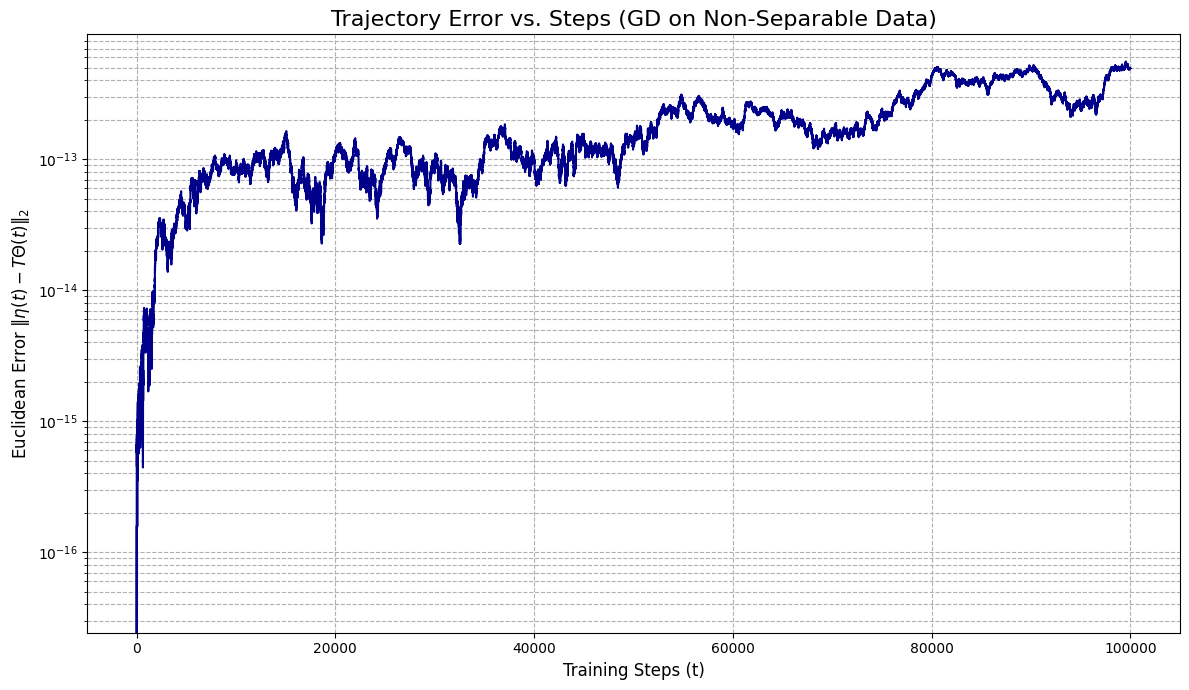

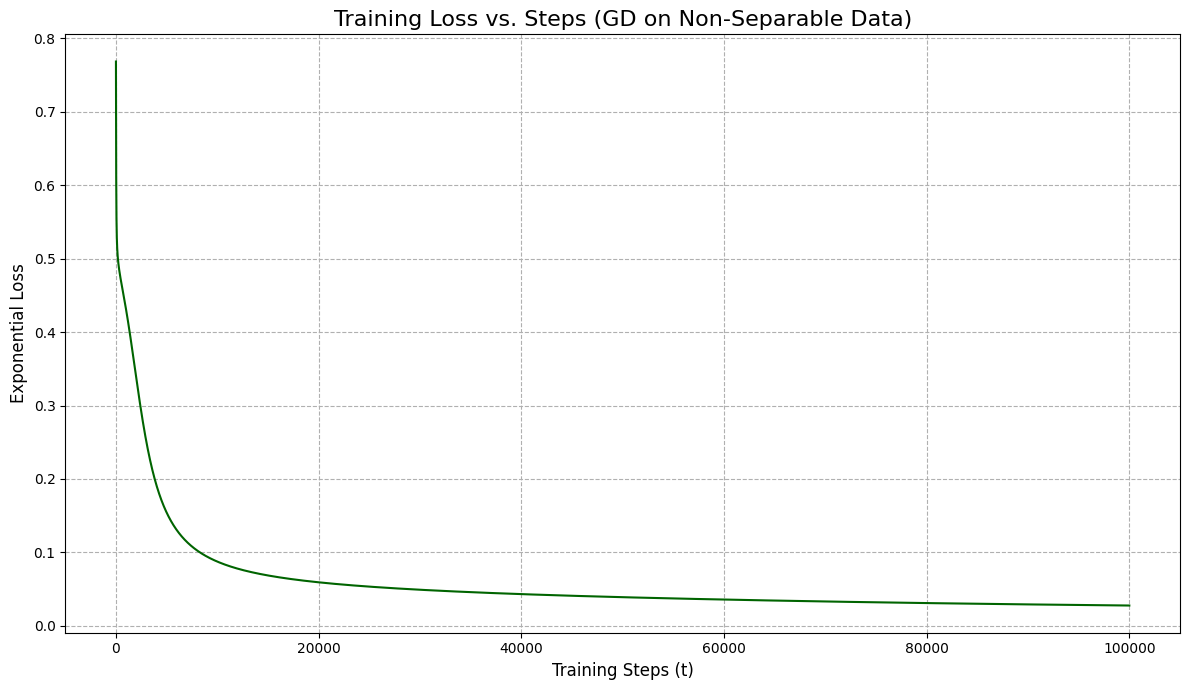


实验3的2张图已生成并保存为PDF。


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Experiment Setup ---
LEARNING_RATE = 0.1 
N_STEPS = 100000       # Total training steps

N_SAMPLES = 100
INPUT_DIM = 2
HIDDEN_DIM_SMALL = 1
HIDDEN_DIM_LARGE = 2
OUTPUT_DIM = 1

torch.manual_seed(123)
np.random.seed(123)

# --- 2. Core Modification: Generate Non-Separable Data ---
def generate_non_separable_data(n_samples=100):
    """
    Generates a non-linearly separable dataset by making the two class clusters overlap.
    """
    dtype = torch.double
    
    # Move cluster centers closer to create overlap
    center1 = torch.tensor([1.0, -1.0], dtype=dtype)
    center2 = torch.tensor([-1.0, 1.0], dtype=dtype)
    
    # Keep the standard deviation the same
    X1 = torch.randn(n_samples // 2, 2, dtype=dtype) * 0.8 + center1
    y1 = torch.ones(n_samples // 2, 1, dtype=dtype)
    
    X2 = torch.randn(n_samples // 2, 2, dtype=dtype) * 0.8 + center2
    y2 = -torch.ones(n_samples // 2, 1, dtype=dtype)
    
    X = torch.cat([X1, X2], dim=0)
    y = torch.cat([y1, y2], dim=0)
    return X, y

# --- 3. Model Forward Pass (same as before) ---
def leaky_relu(x, negative_slope=0.01):
    return torch.where(x > 0, x, x * negative_slope)

def forward_small(params_small, X):
    W_in, W_out = params_small['W_in'], params_small['W_out']
    hidden = leaky_relu(X @ W_in.T)
    output = hidden @ W_out.T
    return output

def forward_large(params_large, X):
    W_in, W_out = params_large['W_in'], params_large['W_out']
    hidden = leaky_relu(X @ W_in.T)
    output = hidden @ W_out.T
    return output

# --- 4. Mapping T (same as before) ---
def transform_params(params_small):
    W_in_small, W_out_small = params_small['W_in'], params_small['W_out']
    c1, c2 = 1.0 / np.sqrt(2), 1.0 / np.sqrt(2)
    W_in_large = torch.cat([c1 * W_in_small, c2 * W_in_small], dim=0)
    W_out_large = torch.cat([c1 * W_out_small, c2 * W_out_small], dim=1)
    return {'W_in': W_in_large, 'W_out': W_out_large}

# --- 5. Loss Function (same as before) ---
def exponential_loss(y_pred, y_true):
    return torch.mean(torch.exp(-y_true * y_pred))

# --- 6. Main Training Loop ---
if __name__ == '__main__':
    # Use the new data generation function
    X, y = generate_non_separable_data(N_SAMPLES)
    dtype = torch.double

    # Initialize network parameters (same as before)
    W_in_s = torch.empty(HIDDEN_DIM_SMALL, INPUT_DIM, dtype=dtype)
    nn.init.kaiming_uniform_(W_in_s, a=math.sqrt(5))
    W_out_s = torch.empty(OUTPUT_DIM, HIDDEN_DIM_SMALL, dtype=dtype)
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W_out_s)
    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
    nn.init.uniform_(W_out_s, -bound, bound)

    params_small = {'W_in': W_in_s.requires_grad_(), 'W_out': W_out_s.requires_grad_()}
    
    params_large_dict = transform_params(params_small)
    params_large = {
        'W_in': params_large_dict['W_in'].clone().detach().requires_grad_(True),
        'W_out': params_large_dict['W_out'].clone().detach().requires_grad_(True)
    }

    # Use SGD optimizer, which is equivalent to GD since we use the full batch in each step.
    optimizer_small = torch.optim.SGD(params_small.values(), lr=LEARNING_RATE)
    optimizer_large = torch.optim.SGD(params_large.values(), lr=LEARNING_RATE)

    error_history = []
    loss_history = []
    
    print("Starting Experiment 3: Full-batch GD on Non-Separable Data...")
    for step in range(N_STEPS):
        # --- Update small network ---
        optimizer_small.zero_grad()
        output_small = forward_small(params_small, X) # Use the full dataset
        loss_small = exponential_loss(output_small, y)
        loss_small.backward()
        optimizer_small.step()
        
        # --- Update wide network ---
        optimizer_large.zero_grad()
        output_large = forward_large(params_large, X) # Use the full dataset
        loss_large = exponential_loss(output_large, y)
        loss_large.backward()
        optimizer_large.step()
        
        # --- Calculate and record error ---
        with torch.no_grad():
            predicted_params_large = transform_params(params_small)
            actual_vec = torch.cat([p.flatten() for p in params_large.values()])
            predicted_vec = torch.cat([p.flatten() for p in predicted_params_large.values()])
            error = torch.norm(actual_vec - predicted_vec).item()
            error_history.append(error)
            loss_history.append(loss_small.item())

        if (step + 1) % (N_STEPS // 10) == 0:
            print(f"Step {step+1}/{N_STEPS}, Loss: {loss_small.item():.6f}, Trajectory Error: {error:.2e}")

    # --- 7. Final Results Summary ---
    print("\n--- Training finished, summarizing results ---")
    max_trajectory_error = max(error_history)
    print(f"Max Trajectory Error: {max_trajectory_error:.4e}")
    
    with torch.no_grad():
        norm_small = torch.norm(torch.cat([p.flatten() for p in params_small.values()]))
        norm_large = torch.norm(torch.cat([p.flatten() for p in params_large.values()]))
    print(f"Final Weight Norm of Small Net: {norm_small:.4f}")
    print(f"Final Weight Norm of Large Net: {norm_large:.4f}")
    print("---------------------------\n")

    # --- 8. Plotting Results ---
    print("Plotting experiment results...")

    # Figure 1: Trajectory Error vs. Training Steps
    plt.figure(figsize=(12, 7))
    plt.plot(error_history, color='darkblue')
    plt.title('Trajectory Error vs. Steps (GD on Non-Separable Data)', fontsize=16)
    plt.xlabel('Training Steps (t)', fontsize=12)
    plt.ylabel('Euclidean Error $\|\eta(t) - T\Theta(t)\|_2$', fontsize=12)
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig("exp3_gd_nonsep_error.pdf")
    plt.show()

    # Figure 2: Training Loss vs. Training Steps
    plt.figure(figsize=(12, 7))
    plt.plot(loss_history, color='darkgreen')
    plt.title('Training Loss vs. Steps (GD on Non-Separable Data)', fontsize=16)
    plt.xlabel('Training Steps (t)', fontsize=12)
    plt.ylabel('Exponential Loss', fontsize=12)
    # For non-separable data, the loss will not converge to 0, so a linear y-axis may be more appropriate.
    # plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig("exp3_gd_nonsep_loss.pdf")
    plt.show()
    
    print("\nAll 2 figures for Experiment 3 have been generated and saved as PDF.")